## Setup

In [1]:
import networkx as nx
from networkx.algorithms import bipartite

import itertools
import random
from math import ceil
from math import fsum

from time import perf_counter
# from tqdm.notebook import trange, tqdm
from tqdm import trange, tqdm

# import matplotlib as mpl
import matplotlib.pyplot as plt

## Utility functions

In [2]:
def draw_edge_set(Gu, edges):
    colors = []
    for (u,v) in Gu.edges:
        if (u,v) in edges or (v,u) in edges:
            colors.append("red")
        else:
            colors.append("black")

    nx.draw_networkx(Gu, edge_color=colors)

In [3]:
def get_path_weight(G, path):
    total_weight = 0
    for u,v in zip(path, path[1:]):
        total_weight += G.edges[u,v]['weight']
    return total_weight

In [4]:
def contract(u, v, orientations):
    if orientations == (0,0):
        return tuple(reversed(u)) + v
    elif orientations == (0,-1):
        return tuple(reversed(u)) + tuple(reversed(v))
    elif orientations == (-1,0):
        return u + v
    elif orientations == (-1,-1):
        return u + tuple(reversed(v))
    else:
        raise ValueError("invalid orientations")

def orient(Gu, u, v):
    oris_list = [(0,0), (0,-1), (-1,0), (-1,-1)]
    u_ori, v_ori = max(oris_list, key = lambda oris: Gu.edges[u[oris[0]],v[oris[1]]]['weight'])
    return (u_ori, v_ori), Gu.edges[u[u_ori],v[v_ori]]['weight']

In [5]:
def info(string, verbose):
    if verbose:
        print(f"%%% {string} %%%")

## Solvers

In [6]:
def via_brute_force(Gu, n, verbose=False):
    path = None
    w_max = 0
    for p in itertools.permutations(range(n)):
        w = get_path_weight(Gu, p)
        if w > w_max:
            path = p
            w_max = w
    return path

In [7]:
def via_matching(Gu, n, verbose=False):
    matching = nx.max_weight_matching(Gu)

    path = []
    for u,v in matching:
        path.append(u)
        path.append(v)
    if n % 2 == 1:
        vertex_sum = n * (n-1) / 2
        final_v = int(vertex_sum - sum(path))
        path.append(final_v)
    
    return tuple(path)

In [8]:
def via_iterated_matching(Gu, n, verbose=False):
    Gk = nx.complete_graph([(i,) for i in range(n)])
    for u in Gk.nodes:
        Gk.nodes[u]['value'] = u[0]  # value is used to efficiently find final vertex when cardinality is odd
    for u,v in Gk.edges:
        Gk.edges[u,v]['orientations'] = (-1,0)
        Gk.edges[u,v]['weight'] = Gu.edges[u[-1],v[0]]['weight']

    num_nodes = n
    while num_nodes > 1:
        info(f"num nodes: {num_nodes}", verbose)
        
        Gk_old = Gk
        Gk = nx.Graph()

        matching = nx.max_weight_matching(Gk_old)

        if num_nodes % 2 == 1:
            value_sum = n * (n-1) / 2
            for u,v in matching:
                value_sum -= Gk_old.nodes[u]['value'] + Gk_old.nodes[v]['value']
            final_value = int(value_sum)
            for u in Gk_old.nodes:
                if Gk_old.nodes[u]['value'] == final_value:
                    fluke = False
                    for x,y in matching:
                        if u in (x,y):
                            fluke = True
                    if not fluke:
                        Gk.add_node(u)
                        Gk.nodes[u]['value'] = final_value

        for u,v in matching:
            node = contract(u, v, Gk_old.edges[u,v]['orientations'])
            Gk.add_node(node)
            Gk.nodes[node]['value'] = Gk_old.nodes[u]['value'] + Gk_old.nodes[v]['value']

        for u in Gk.nodes:
            for v in Gk.nodes:
                if u != v:
                    oris, w = orient(Gu, u, v)
                    Gk.add_edge(u, v, orientations=oris, weight=w)

        num_nodes = len(Gk.nodes)

    for u in Gk.nodes:
        assert Gk.nodes[u]['value'] == n * (n-1) / 2

    return next(iter(Gk.nodes))

WARNING: NetworkX uses an assignment problem solver other than the Hungarian method

In [9]:
def via_cycle_cover(Gu, n, verbose=False):
    Gb = nx.Graph()
    for i in range(2*n):
        Gb.add_node(i)
    for u,v in Gu.edges:
        Gb.add_edge(u, v+n, weight=1-Gu.edges[u,v]['weight'])  # account for min weight NetworkX method
        Gb.add_edge(v, u+n, weight=1-Gu.edges[u,v]['weight'])  # account for min weight NetworkX method

    mb_dict = bipartite.minimum_weight_full_matching(Gb, top_nodes=list(Gb.nodes)[:n])
    # draw_edge_set(Gb, list(mb_dict.items()))

    m_dict = {}
    for u,v in mb_dict.items():
        if u < n:
            x,y = u,v
        else:
            x,y = v,u
        m_dict[x] = y-n
    # draw_edge_set(Gu, list(m_dict.items()))


    cycle_cover = []

    done = set()
    cycle = []
    start = curr = 0

    while True:
        cycle.append(curr)
        done.add(curr)
        curr = m_dict[curr]
        if curr == start:
            cycle_cover.append(cycle)
            cycle = []
            flag = False
            for i in range(n):
                if i not in done:
                    start = curr = i
                    flag = True
                    break
            if not flag:
                break

    path_cover = []
    for cycle in cycle_cover:
        best_start = cycle[0]
        best_start_idx = 0
        min_weight = Gu.edges[cycle[-1],cycle[0]]['weight']
        for i, (u,v) in enumerate(zip(cycle, cycle[1:])):
            if Gu.edges[u,v]['weight'] < min_weight:
                best_start = v
                best_start_idx = i+1
                min_weight = Gu.edges[u,v]['weight']
        path = cycle[best_start_idx:] + cycle[:best_start_idx]
        path_cover.append(path)

    return tuple(itertools.chain(*path_cover))

In [10]:
def via_iterated_cycle_cover(Gu, n, verbose=False):
    Gk = nx.complete_graph([(i,) for i in range(n)])
    num_nodes = n  
    
    while num_nodes > 1:
        info(f"num nodes: {num_nodes}", verbose)
        
        Gb = nx.Graph()
        for u in Gk.nodes:
            Gb.add_node(u)
            Gb.add_node(tuple([i + n for i in u]))
        for u,v in Gk.edges:
            Gb.add_edge(u, tuple([i + n for i in v]), weight=1-Gu.edges[u[-1],v[0]]['weight'])  # account for min weight NetworkX method
            Gb.add_edge(v, tuple([i + n for i in u]), weight=1-Gu.edges[u[-1],v[0]]['weight'])  # account for min weight NetworkX method
        
        mb_dict = bipartite.minimum_weight_full_matching(Gb, top_nodes=list(Gb.nodes)[::2])
        # draw_edge_set(Gb, list(mb_dict.items()))

        m_dict = {}
        for u,v in mb_dict.items():
            if u[0] < n:
                x,y = u,v
            else:
                x,y = v,u
            m_dict[x] = tuple([i - n for i in y])
        # draw_edge_set(Gu, list(m_dict.items()))


        cycle_cover = []

        done = set()
        cycle = []
        start = curr = next(iter(m_dict))  # start with arbitrary node

        while True:
            cycle.append(curr)
            done.add(curr)
            curr = m_dict[curr]
            if curr == start:
                cycle_cover.append(cycle)
                cycle = []
                flag = False
                for i in m_dict:
                    if i not in done:
                        start = curr = i
                        flag = True
                        break
                if not flag:
                    break

        path_cover = []
        for cycle in cycle_cover:
            best_start = cycle[0]
            best_start_idx = 0
            min_weight = Gu.edges[cycle[-1][-1],cycle[0][0]]['weight']
            for i, (u,v) in enumerate(zip(cycle, cycle[1:])):
                if Gu.edges[u[-1],v[0]]['weight'] < min_weight:
                    best_start = v
                    best_start_idx = i+1
                    min_weight = Gu.edges[u[-1],v[0]]['weight']
            path = cycle[best_start_idx:] + cycle[:best_start_idx]
            
            path_flattened = list(path[0])
            for p in path[1:]:
                if Gu.edges[path_flattened[-1],p[0]]['weight'] > Gu.edges[path_flattened[-1],p[-1]]['weight']:
                    path_flattened.extend(p)
                else:
                    path_flattened.extend(tuple(reversed(p)))
            path_cover.append(tuple(path_flattened))
        

        Gk = nx.Graph()
        for u in path_cover:
            Gk.add_node(u)
        for u in Gk.nodes:
            for v in Gk.nodes:
                if u != v:
                    Gk.add_edge(u,v)
        num_nodes = len(Gk.nodes)

    return next(iter(Gk.nodes))

## Experiments

In [11]:
def avg(Ns):
    return fsum(Ns) / len(Ns)

def neutrality(G, path, agg):
    Ns = []
    for u,v in zip(path, path[1:]):
        Ns.append(G.edges[u,v]['weight'])
    return agg(Ns)

In [12]:
n = 100
Gu = nx.complete_graph(n)
for (u,v) in Gu.edges:
    Gu.edges[u,v]['weight'] = random.random()

In [13]:
solvers = [via_matching, via_iterated_matching, via_cycle_cover, via_iterated_cycle_cover]

solver_names = [func.__name__[4:].replace('_', ' ') for func in solvers]

In [14]:
for func, name in zip(solvers, solver_names):
    print(f"solver: {name}")
    start = perf_counter()
    p = func(Gu, n, verbose=True)
    t = perf_counter() - start
    neut = neutrality(Gu, p, avg)
    print(f"Neut_avg: {neut}\ntime (s): {t}\n")

solver: matching
Neut_avg: 0.7442906042426731
time (s): 1.7566059999999197

solver: iterated matching
%%% num nodes: 100 %%%
%%% num nodes: 50 %%%
%%% num nodes: 25 %%%
%%% num nodes: 13 %%%
%%% num nodes: 7 %%%
%%% num nodes: 4 %%%
%%% num nodes: 2 %%%
Neut_avg: 0.8874284698070316
time (s): 1.9821603000000323

solver: cycle cover
Neut_avg: 0.7191360285888592
time (s): 4.645644499999889

solver: iterated cycle cover
%%% num nodes: 100 %%%
%%% num nodes: 49 %%%
%%% num nodes: 19 %%%
%%% num nodes: 8 %%%
%%% num nodes: 4 %%%
%%% num nodes: 2 %%%
Neut_avg: 0.9347008022165818
time (s): 0.1064728000001196



In [15]:
n_domain = range(10, 100, 10)

In [16]:
neuts = []
times = []
for n in tqdm(n_domain):
    Gu = nx.complete_graph(n)
    for (u,v) in Gu.edges:
        Gu.edges[u,v]['weight'] = random.random()
    
    inner_neuts = []
    inner_times = []
    for func in solvers:
        first = True
        iterations = 10  # 5 is the standard in the timeit module
        for i in range(iterations):
            start = perf_counter()
            p = func(Gu, n)
            t = perf_counter() - start
            neut = neutrality(Gu, p, avg)
            if first:
                time_min = t
                first = False
            else:
                time_min = min(time_min, t)  
        inner_neuts.append(neut)  # the solvers are deterministic
        inner_times.append(time_min)
    neuts.append(inner_neuts)
    times.append(inner_times)

100%|█████████████████████████████████████████████████████████████████| 9/9 [01:21<00:00,  9.05s/it]


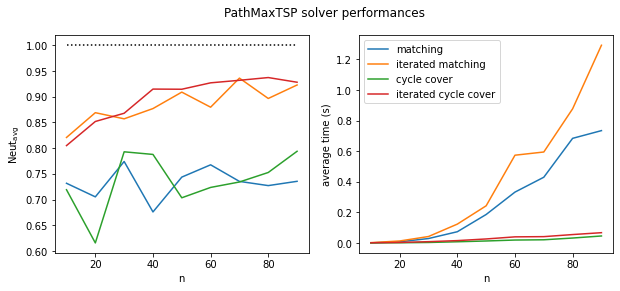

In [17]:
# %matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('PathMaxTSP solver performances')

axes[0].plot(n_domain, neuts)
axes[0].plot(n_domain, [1 for _ in n_domain], label='upper bound', color='black', linestyle=':')
axes[0].set_xlabel('n')
axes[0].set_ylabel(r'$\operatorname{Neut}_{\operatorname{avg}}$')

axes[1].plot(n_domain, times, label=solver_names)
axes[1].set_xlabel('n')
axes[1].set_ylabel('average time (s)')

# axes[0].legend()
axes[1].legend()